Number of rows after imputation: 2467
Random Forest MSE: 76537.32, R2: 0.99, MAE: 96.58
Training and testing time for Random Forest: 2.794644355773926 seconds
MLP Regressor MSE: 628095.06, R2: 0.92, MAE: 335.06
Training  and testing time for MLP Regressor: 3.5924527645111084 seconds
XGBoost MSE: 43084.91, R2: 0.99, MAE: 78.98
Trainining and testing time for XGBoost model: 0.3244588375091553 seconds


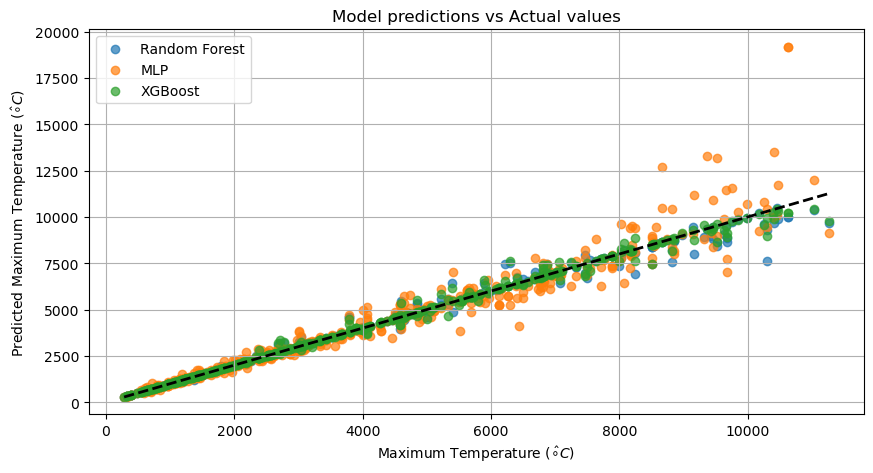

Random Forest CV MAE: 260.16 ± 198.16
MLP Regressor CV MAE: 573.32 ± 391.97
XGBoost CV MAE: 262.38 ± 213.76
Random Forest fit: y = 1.12e-06 * x^1.84
MLP fit: y = 4.60e-03 * x^1.27
XGBoost fit: y = 2.60e-05 * x^1.60


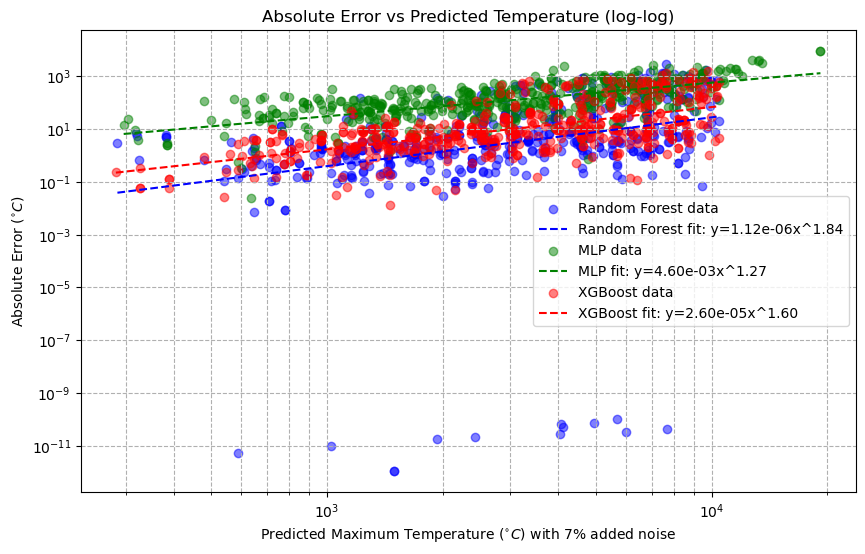

Random Forest (vs T_max): log10(abs error) = 1.84 * log10(T_max) + -5.93
MLP (vs T_max): log10(abs error) = 1.26 * log10(T_max) + -2.30
XGBoost (vs T_max): log10(abs error) = 1.59 * log10(T_max) + -4.55


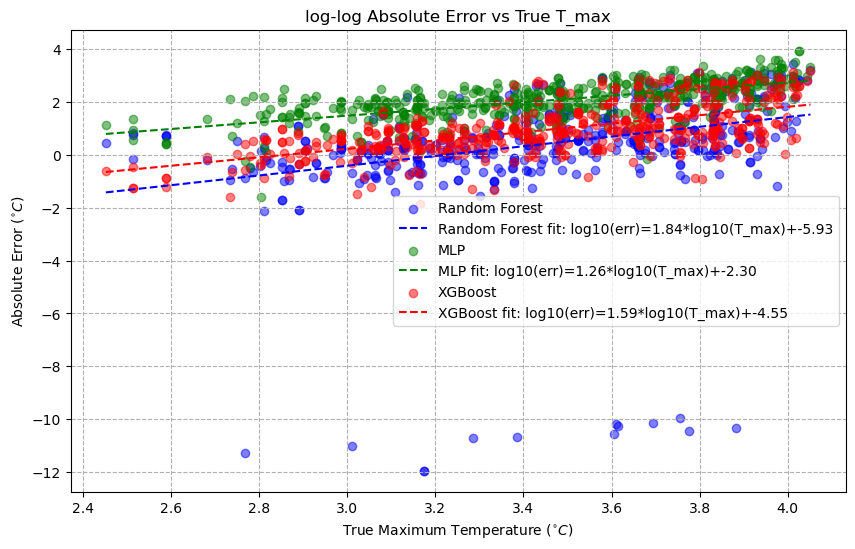

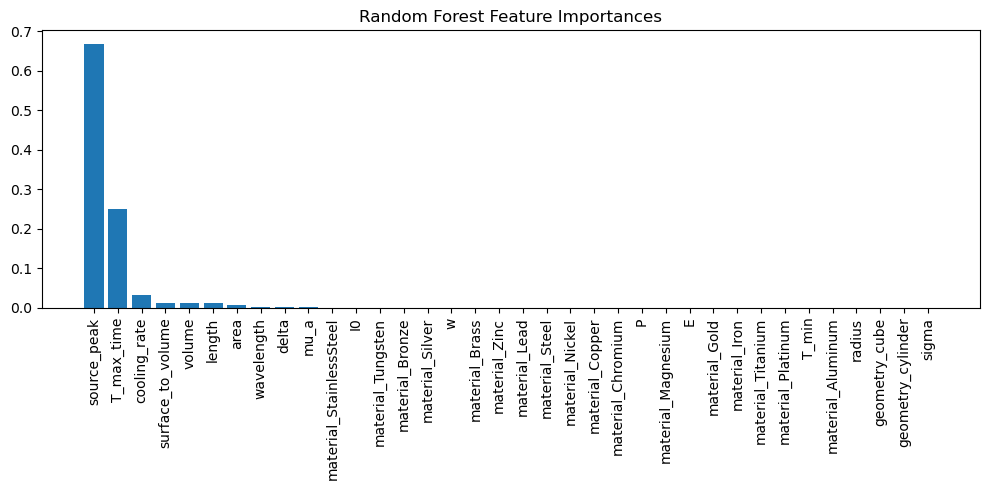

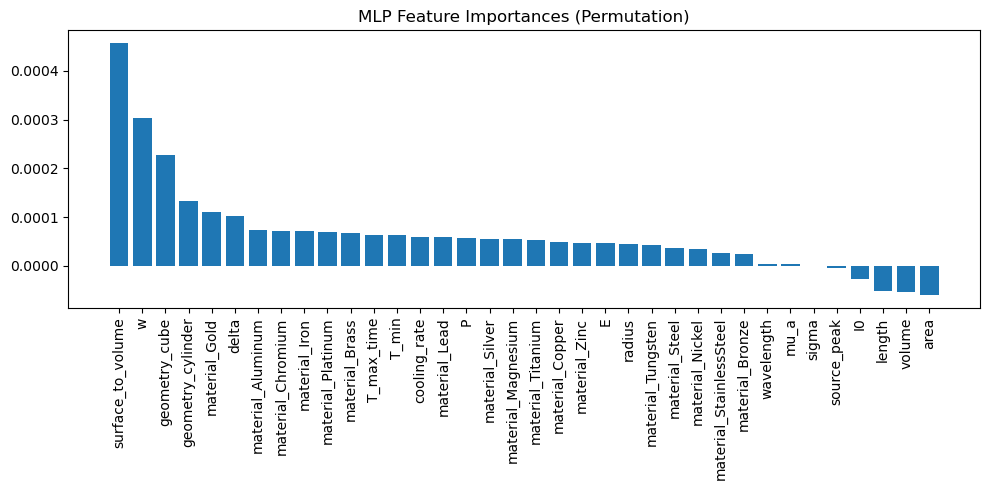

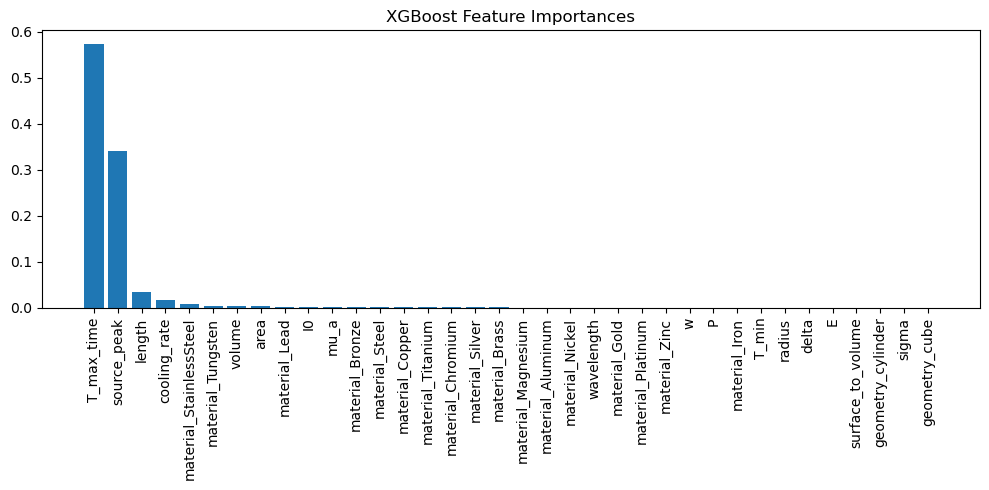

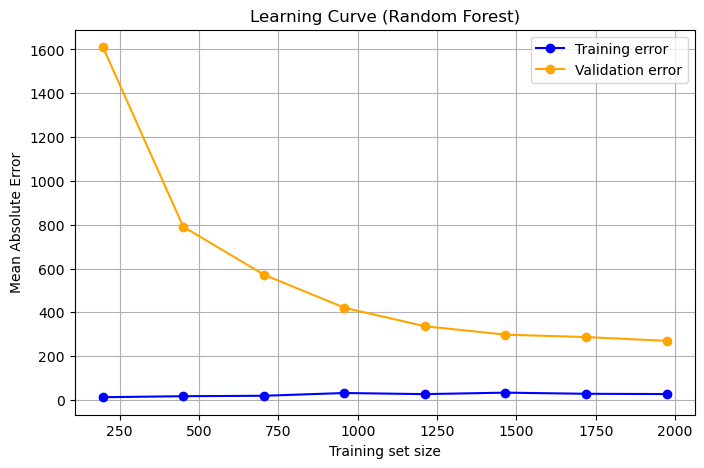

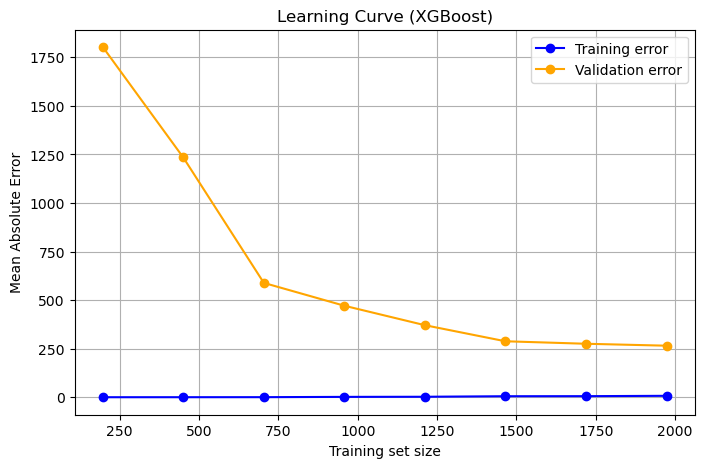

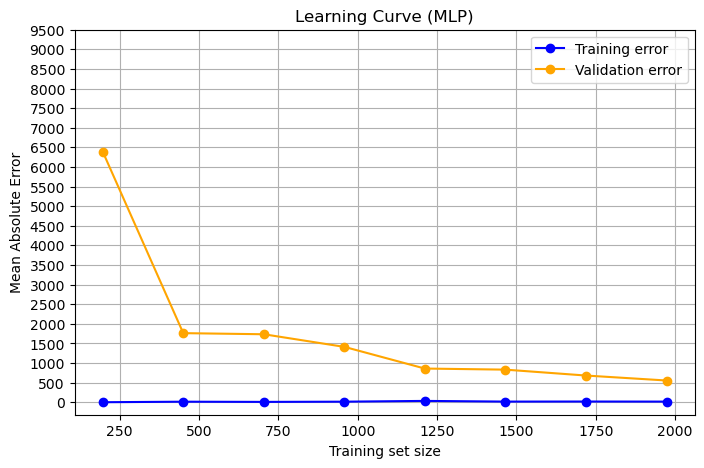

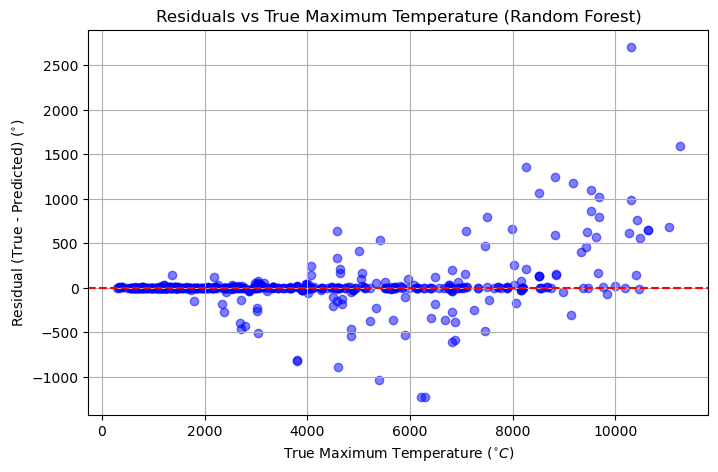

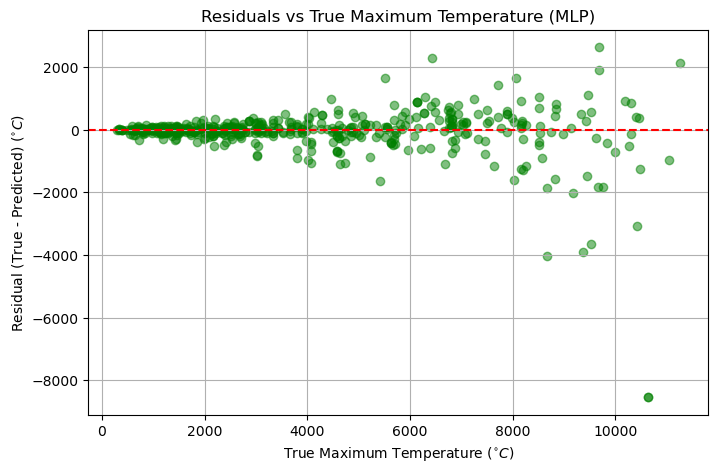

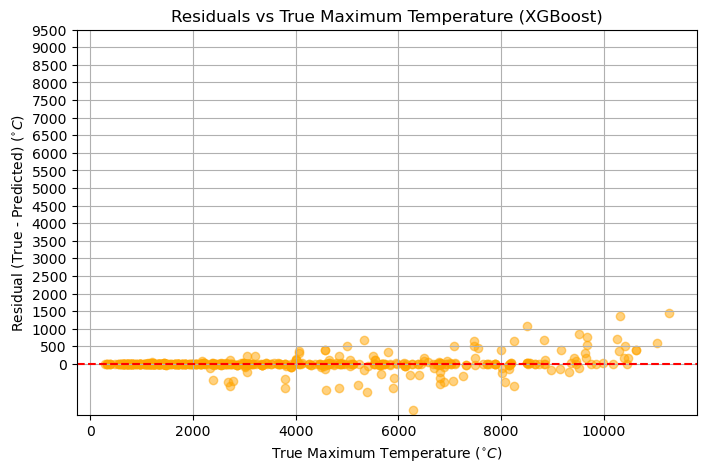

The program to compare the three models is now finished
Next program is now starting, the aim of the next program is to test the machine learning models
and compare them againts real data, to find out which model is the best one
New program starting to test the data now

--- Enhanced Model Evaluation Metrics ---

Random Forest:
  MAE: 120.972 °C
  Median AE: 49.352 °C
  MAPE: 2.43 %
  R² Score: 0.9916
  95% CI of prediction error: [-460.29, 345.44] °C
  Prediction time: 0.1103 seconds

MLP:
  MAE: 45600.454 °C
  Median AE: 1260.793 °C
  MAPE: 979.51 %
  R² Score: -2880.0729
  95% CI of prediction error: [-2225.37, 456375.49] °C
  Prediction time: 0.0353 seconds

XGBoost:
  MAE: 98.089 °C
  Median AE: 48.632 °C
  MAPE: 1.91 %
  R² Score: 0.9938
  95% CI of prediction error: [-379.16, 251.68] °C
  Prediction time: 0.1194 seconds

Random Forest std error: 238.91 °C
MLP std error: 132533.64 °C
XGBoost std error: 202.81 °C


In [1]:
# The aim of this program is to train machine learning models based on
# data generated previously from a simulation. Then conduct a study to find the 
# optimal model for physics simulations to minimize errors.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import os
import time

os.makedirs('figures_for_machine_learning_project', exist_ok=True) #Creating a new folder to store data

# Importing necessary sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer  # For imputing missing features
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance

# data to test on later on
#data_1 = pd.read_csv('heat_flux_data_day_1.csv', on_bad_lines='skip')
#data_2 = pd.read_csv('heat_flux_data_day_2.csv', on_bad_lines='skip')

#Testing data later
#data_raw_to_test_model = pd.concat([data_1, data_2], ignore_index=True)
data_raw = pd.read_csv('heat_flux_data_day_3_partial.csv')

# Remove rows with unrealistic or non-physical temperatures
data = data_raw[data_raw['T_max_noisy'] < 10000]

# Encode non-numeric categorical columns if they exist
for col in ['geometry', 'material']:
    if col in data.columns:
        data = pd.get_dummies(data, columns=[col])

# Convert all columns to numeric values (coerce errors to NaN)
data = data.apply(pd.to_numeric, errors='coerce')

# Drop columns that cannot be used as numeric features (e.g., time series columns)
if 'T_center_time_series' in data.columns:
    data = data.drop(columns=['T_center_time_series'])

# Target variable: T_max_noisy
X = data.drop(columns=['T_max_noisy', 'T_max','T_avg','T_avg_noisy','T_var','T_var_noisy','T_median','T_90th'])  # drop target and others not used
y = data['T_max']

# Drop all-NaN columns
X = X.dropna(axis=1, how='all')

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Scale for MLP and XGBoost
scaler = StandardScaler()
X_imputed_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)
print(f"Number of rows after imputation: {X_imputed.shape[0]}")

# Split train/test data
X_train, X_test, y_train, y_test = train_test_split(X_imputed_scaled, y, test_size=0.2, random_state=42)

# Log transform target
y_train_log = np.log1p(y_train)

# --- Model Training and Evaluation ---
# Random Forest
start_time = time.time()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_log)
y_pred_log_rf = rf.predict(X_test)
y_pred_rf = np.expm1(y_pred_log_rf)
end_time = time.time()
print(f"Random Forest MSE: {mean_squared_error(y_test, y_pred_rf):.2f}, R2: {r2_score(y_test, y_pred_rf):.2f}, MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"Training and testing time for Random Forest: {end_time - start_time} seconds")
training_and_testing_time_rf = end_time - start_time
# MLP
start_time = time.time()
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=15000, random_state=42)
mlp.fit(X_train, y_train_log)
y_pred_log_mlp = np.clip(mlp.predict(X_test), a_min=None, a_max=20)
y_pred_mlp = np.expm1(y_pred_log_mlp)
end_time = time.time()
print(f"MLP Regressor MSE: {mean_squared_error(y_test, y_pred_mlp):.2f}, R2: {r2_score(y_test, y_pred_mlp):.2f}, MAE: {mean_absolute_error(y_test, y_pred_mlp):.2f}")
print(f"Training  and testing time for MLP Regressor: {end_time - start_time} seconds")
training_and_testing_time_MLP = end_time - start_time

# XGBoost
start_time = time.time()
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train_log)
y_pred_log_xgb = xgb.predict(X_test)
y_pred_xgb = np.expm1(y_pred_log_xgb)
end_time = time.time()
print(f"XGBoost MSE: {mean_squared_error(y_test, y_pred_xgb):.2f}, R2: {r2_score(y_test, y_pred_xgb):.2f}, MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"Trainining and testing time for XGBoost model: {end_time - start_time} seconds")
training_and_testing_time_XGboost = end_time - start_time
# --- Model Prediction vs Actual Plot ---
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_rf, label='Random Forest', alpha=0.7)
plt.scatter(y_test, y_pred_mlp, label='MLP', alpha=0.7)
plt.scatter(y_test, y_pred_xgb, label='XGBoost', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Maximum Temperature ($\^{\circ} C$)')
plt.ylabel('Predicted Maximum Temperature ($\^{\circ} C$)')
plt.legend()
plt.grid(True)
plt.title('Model predictions vs Actual values')
plt.savefig('figures_for_machine_learning_project/Model_prediction_vs_actual_various_plots_various_models.png', dpi = 300)
plt.show()

# --- Cross-validation for each model ---
rf_scores = cross_val_score(rf, X_imputed, y, cv=5, scoring='neg_mean_absolute_error')
mlp_scores = cross_val_score(make_pipeline(StandardScaler(), mlp), X_imputed, y, cv=5, scoring='neg_mean_absolute_error')
xgb_scores = cross_val_score(xgb, X_imputed, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Random Forest CV MAE: {-rf_scores.mean():.2f} ± {rf_scores.std():.2f}")
print(f"MLP Regressor CV MAE: {-mlp_scores.mean():.2f} ± {mlp_scores.std():.2f}")
print(f"XGBoost CV MAE: {-xgb_scores.mean():.2f} ± {xgb_scores.std():.2f}")

#Saving the statistical data
# Save model performance to CSV
results = pd.DataFrame({
    'Model': ['Random Forest', 'MLP', 'XGBoost'],
    'MSE': [
        mean_squared_error(y_test, y_pred_rf),
        mean_squared_error(y_test, y_pred_mlp),
        mean_squared_error(y_test, y_pred_xgb)
    ],
    'MAE': [
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_mlp),
        mean_absolute_error(y_test, y_pred_xgb)
    ],
    'R2': [
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_mlp),
        r2_score(y_test, y_pred_xgb)
    ],
    'Training_Testing_Time(s)': [
        training_and_testing_time_rf,
        training_and_testing_time_MLP,
        training_and_testing_time_XGboost
    ]
})
results.to_csv('figures_for_machine_learning_project/model_performance_metrics.csv', index=False)

# --- Log-log Absolute Error vs Predicted T_max ---
def plot_error_vs_pred(y_true, y_pred, model_name, color):
    abs_error = np.abs(y_true - y_pred)
    mask = (abs_error > 0) & (y_pred > 0)
    x = y_pred[mask]
    y = abs_error[mask]
    log_x, log_y = np.log10(x), np.log10(y)
    reg = LinearRegression().fit(log_x.reshape(-1, 1), log_y)
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = 10**reg.intercept_ * x_fit**reg.coef_[0]
    plt.scatter(x, y, alpha=0.5, label=f'{model_name} data', color=color)
    plt.plot(x_fit, y_fit, '--', color=color,
             label=f'{model_name} fit: y={10**reg.intercept_:.2e}x^{reg.coef_[0]:.2f}')
    print(f"{model_name} fit: y = {10**reg.intercept_:.2e} * x^{reg.coef_[0]:.2f}")

plt.figure(figsize=(10, 6))
plot_error_vs_pred(y_test.values, y_pred_rf, 'Random Forest', 'blue')
plot_error_vs_pred(y_test.values, y_pred_mlp, 'MLP', 'green')
plot_error_vs_pred(y_test.values, y_pred_xgb, 'XGBoost', 'red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Predicted Maximum Temperature ($^{\circ} C$) with 7% added noise')
plt.ylabel('Absolute Error ($^{\circ} C$)')
plt.title('Absolute Error vs Predicted Temperature (log-log)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# --- Log-log Absolute Error vs True T_max ---
def plot_log_error_vs_true(y_true, y_pred, model_name, color):
    abs_error = np.abs(y_true - y_pred)
    mask = (abs_error > 0) & (y_true > 0)
    log_true = np.log10(y_true[mask])
    log_err = np.log10(abs_error[mask])
    reg = LinearRegression().fit(log_true.reshape(-1, 1), log_err)
    plt.scatter(log_true, log_err, alpha=0.5, label=model_name, color=color)
    plt.plot(np.sort(log_true), reg.predict(np.sort(log_true).reshape(-1, 1)),
             linestyle='--', color=color,
             label=f'{model_name} fit: log10(err)={reg.coef_[0]:.2f}*log10(T_max)+{reg.intercept_:.2f}')
    print(f"{model_name} (vs T_max): log10(abs error) = {reg.coef_[0]:.2f} * log10(T_max) + {reg.intercept_:.2f}")

plt.figure(figsize=(10, 6))
plot_log_error_vs_true(y_test.values, y_pred_rf, 'Random Forest', 'blue')
plot_log_error_vs_true(y_test.values, y_pred_mlp, 'MLP', 'green')
plot_log_error_vs_true(y_test.values, y_pred_xgb, 'XGBoost', 'red')
plt.xlabel('True Maximum Temperature ($^{\circ} C$)')
plt.ylabel('Absolute Error ($^{\circ} C$)')
plt.title('log-log Absolute Error vs True T_max')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.savefig('figures_for_machine_learning_project/Absolute_error_vs_true_max_temp.png', dpi = 300)
plt.show()

# --- Random Forest Feature Importances ---
importances_rf = rf.feature_importances_
feature_names = X_imputed_scaled.columns
indices = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Random Forest Feature Importances")
plt.bar(range(len(importances_rf)), importances_rf[indices], align="center")
plt.xticks(range(len(importances_rf)), list(feature_names[indices]), rotation=90)
plt.tight_layout()
plt.savefig('figures_for_machine_learning_project/bar_chart_rf_importances.png', dpi=300)
plt.show()

# Calculate permutation importance for MLP
result_mlp = permutation_importance(mlp, X_test, y_test, n_repeats=10, random_state=42)

importances_mlp = result_mlp.importances_mean
indices_mlp = np.argsort(importances_mlp)[::-1]

plt.figure(figsize=(10, 5))
plt.title("MLP Feature Importances (Permutation)")
plt.bar(range(len(importances_mlp)), importances_mlp[indices_mlp], align="center")
plt.xticks(range(len(importances_mlp)), list(feature_names[indices_mlp]), rotation=90)
plt.tight_layout()
plt.savefig('figures_for_machine_learning_project/bar_chart_of_the_most_important_features_MLP.png', dpi=300)
plt.show()

# --XGRBOOST Feature Importances -- 
importances_XGB = xgb.feature_importances_
indices_XGB = np.argsort(importances_XGB)[::-1]

plt.figure(figsize=(10, 5))  
plt.title("XGBoost Feature Importances")
plt.bar(range(len(importances_XGB)), importances_XGB[indices_XGB], align="center")
plt.xticks(range(len(importances_XGB)), list(feature_names[indices_XGB]), rotation=90)  
plt.tight_layout()
plt.savefig('figures_for_machine_learning_project/bar_chart_of_the_most_important_features_XGB.png', dpi=300)
plt.show()

#Save features of importance data
# Save RF, MLP, and XGB feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'RF_Importance': importances_rf,
    'MLP_Importance': importances_mlp,
    'XGB_Importance': importances_XGB
})
feature_importance_df.to_csv('figures_for_machine_learning_project/feature_importances.csv', index=False)

# --- Learning Curve for Random Forest ---
train_sizes, train_scores, test_scores = learning_curve(
    rf, X_imputed_scaled, y, cv=5, scoring='neg_mean_absolute_error',
    train_sizes=np.linspace(0.1, 1.0, 8)
)
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Curve (Random Forest)')
plt.legend()
plt.grid(True)
plt.savefig('figures_for_machine_learning_project/Mean_abs_error_vs_Training_set_size.png', dpi = 300)
plt.show()

#Learning curve data for XGBoost
train_sizes_xgb, train_scores_xgb, test_scores_xgb = learning_curve(
    xgb,                          # XGBoost model
    X_imputed_scaled,            # Features (scaled)
    y,                           # Target values
    cv=5,                        # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # Metric: negative MAE
    train_sizes=np.linspace(0.1, 1.0, 8)  # Fraction of training set sizes to evaluate
)

# Convert negative scores to positive mean absolute error
train_scores_mean_xgb = -np.mean(train_scores_xgb, axis=1)
test_scores_mean_xgb = -np.mean(test_scores_xgb, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes_xgb, train_scores_mean_xgb, 'o-', color='blue', label='Training error')
plt.plot(train_sizes_xgb, test_scores_mean_xgb, 'o-', color='orange', label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Curve (XGBoost)')
plt.legend()
plt.grid(True)
plt.savefig('figures_for_machine_learning_project/learning_curve_XGBoost.png', dpi=300)
plt.show()

# Create a pipeline to scale inputs and train MLP
mlp_pipeline = make_pipeline(
    StandardScaler(),                              # Standardize input features
    MLPRegressor(hidden_layer_sizes=(100, 50),     # Two hidden layers
                 max_iter=15000,                    # Max training iterations
                 random_state=42)                  # For reproducibility
)

# Compute learning curve data for MLP pipeline
train_sizes_mlp, train_scores_mlp, test_scores_mlp = learning_curve(
    mlp_pipeline,              # MLP with preprocessing
    X_imputed,                 # Use unscaled data (scaling is in pipeline)
    y,                         # Target values
    cv=5,                      # 5-fold cross-validation
    scoring='neg_mean_absolute_error',
    train_sizes=np.linspace(0.1, 1.0, 8)
)

# Convert to positive MAE
train_scores_mean_mlp = -np.mean(train_scores_mlp, axis=1)
test_scores_mean_mlp = -np.mean(test_scores_mlp, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes_mlp, train_scores_mean_mlp, 'o-', color='blue', label='Training error')
plt.plot(train_sizes_mlp, test_scores_mean_mlp, 'o-', color='orange', label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('Mean Absolute Error')
plt.yticks(np.arange(0,10000, 500))
plt.title('Learning Curve (MLP)')
plt.legend()
plt.grid(True)
plt.savefig('figures_for_machine_learning_project/learning_curve_MLP.png', dpi=300)
plt.show()

# Save learning curve data
lc_rf = pd.DataFrame({
    'Training_Size': train_sizes,
    'Train_MAE_RF': train_scores_mean,
    'Test_MAE_RF': test_scores_mean
})
lc_rf.to_csv('figures_for_machine_learning_project/learning_curve_random_forest.csv', index=False)

lc_xgb = pd.DataFrame({
    'Training_Size': train_sizes_xgb,
    'Train_MAE_XGB': train_scores_mean_xgb,
    'Test_MAE_XGB': test_scores_mean_xgb
})
lc_xgb.to_csv('figures_for_machine_learning_project/learning_curve_xgb.csv', index=False)

lc_mlp = pd.DataFrame({
    'Training_Size': train_sizes_mlp,
    'Train_MAE_MLP': train_scores_mean_mlp,
    'Test_MAE_MLP': test_scores_mean_mlp
})
lc_mlp.to_csv('figures_for_machine_learning_project/learning_curve_mlp.csv', index=False)

# --- Residual Plot for Random forest ---
residuals_rf = y_test.values - y_pred_rf
plt.figure(figsize=(8, 5))
plt.scatter(y_test.values, residuals_rf, alpha=0.5, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True Maximum Temperature ($^{\circ} C$)')
plt.ylabel('Residual (True - Predicted) ($^{\circ}$)')
plt.title('Residuals vs True Maximum Temperature (Random Forest)')
plt.grid(True)
plt.savefig('figures_for_machine_learning_project/Residuals_plot.png', dpi = 300)
plt.show()

# --- Residual Plot for MLP ---
residuals_mlp = y_test.values - y_pred_mlp
plt.figure(figsize=(8, 5))
plt.scatter(y_test.values, residuals_mlp, alpha=0.5, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True Maximum Temperature ($^{\circ} C$)')
plt.ylabel('Residual (True - Predicted) ($^{\circ} C$)')
plt.title('Residuals vs True Maximum Temperature (MLP)')
plt.grid(True)
plt.savefig('figures_for_machine_learning_project/Residuals_plot_MLP.png', dpi=300)
plt.show()

# --- Residual Plot for XGBoost ---
residuals_xgb = y_test.values - y_pred_xgb
plt.figure(figsize=(8, 5))
plt.scatter(y_test.values, residuals_xgb, alpha=0.5, color='orange')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True Maximum Temperature ($^{\circ} C$)')
plt.ylabel('Residual (True - Predicted) ($^{\circ} C$)')
plt.yticks(np.arange(0,10000,500))
plt.title('Residuals vs True Maximum Temperature (XGBoost)')
plt.grid(True)
plt.savefig('figures_for_machine_learning_project/Residuals_plot_XGB.png', dpi=300)
plt.show()
print("The program to compare the three models is now finished")
print("Next program is now starting, the aim of the next program is to test the machine learning models")
print("and compare them againts real data, to find out which model is the best one")

#Program is now finished
#For completness, i show the code used to test all 3 models in here, however, it will be more efficient
#to test this as a seperate program. 

#Saving all 3 models to the figures folder
# Save each model
import joblib

# Save trained models
joblib.dump(rf, 'figures_for_machine_learning_project/random_forest_model.pkl')
joblib.dump(mlp, 'figures_for_machine_learning_project/mlp_model.pkl')
joblib.dump(xgb, 'figures_for_machine_learning_project/xgboost_model.pkl')

# Also save the scaler and imputer so you can preprocess test data the same way
joblib.dump(scaler, 'figures_for_machine_learning_project/scaler.pkl')
joblib.dump(imputer, 'figures_for_machine_learning_project/imputer.pkl')

# Save the list of columns used for training
import joblib
joblib.dump(list(X_imputed.columns), 'figures_for_machine_learning_project/training_columns.pkl')


print("New program starting to test the data now")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    median_absolute_error,
    r2_score
)
import joblib
import time

# ----------------------
# Helper Functions
# ----------------------

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate MAPE with zero-safe division."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def confidence_interval(errors, confidence=0.95):
    """Calculate percentile-based confidence interval for errors."""
    lower = np.percentile(errors, (1 - confidence) / 2 * 100)
    upper = np.percentile(errors, (1 + confidence) / 2 * 100)
    return lower, upper

# ----------------------
# Load Saved Models and Preprocessing Objects
# ----------------------

rf_model = joblib.load("figures_for_machine_learning_project/random_forest_model.pkl")
mlp_model = joblib.load("figures_for_machine_learning_project/mlp_model.pkl")
xgb_model = joblib.load("figures_for_machine_learning_project/xgboost_model.pkl")

imputer = joblib.load("figures_for_machine_learning_project/imputer.pkl")
scaler = joblib.load("figures_for_machine_learning_project/scaler.pkl")
training_columns = joblib.load("figures_for_machine_learning_project/training_columns.pkl")

# ----------------------
# Load and Preprocess Test Data
# ----------------------

data_1 = pd.read_csv('heat_flux_data_day_1.csv', on_bad_lines='skip')
data_2 = pd.read_csv('heat_flux_data_day_2.csv', on_bad_lines='skip')
data_raw_to_test = pd.concat([data_1, data_2], ignore_index=True)

# Filter out unphysical temperature values
data_to_test = data_raw_to_test[data_raw_to_test['T_max_noisy'] < 10000].copy()
y_true = data_to_test['T_max'].copy()  # Save ground truth

# One-hot encode categorical variables
for col in ['geometry', 'material']:
    if col in data_to_test.columns:
        data_to_test = pd.get_dummies(data_to_test, columns=[col])

# Drop target and derived features
cols_to_drop = [
    'T_center_time_series', 'T_max_noisy', 'T_max', 'T_avg', 'T_avg_noisy',
    'T_var', 'T_var_noisy', 'T_median', 'T_90th'
]
for col in cols_to_drop:
    if col in data_to_test.columns:
        data_to_test.drop(columns=[col], inplace=True)

X_test = data_to_test.copy()

# Ensure feature columns match training
for col in training_columns:
    if col not in X_test.columns:
        X_test[col] = 0

for col in X_test.columns:
    if col not in training_columns:
        X_test.drop(columns=[col], inplace=True)

X_test = X_test[training_columns]

# Impute and scale
X_imputed = pd.DataFrame(imputer.transform(X_test), columns=training_columns)
X_scaled = pd.DataFrame(scaler.transform(X_imputed), columns=training_columns)

# ----------------------
# Predict and Time Each Model
# ----------------------

start = time.time()
y_pred_rf = np.expm1(rf_model.predict(X_scaled))
rf_time = time.time() - start

start = time.time()
y_pred_mlp = np.expm1(np.clip(mlp_model.predict(X_scaled), a_min=None, a_max=20))
mlp_time = time.time() - start

start = time.time()
y_pred_xgb = np.expm1(xgb_model.predict(X_scaled))
xgb_time = time.time() - start

models = {
    "Random Forest": (y_pred_rf, rf_time),
    "MLP": (y_pred_mlp, mlp_time),
    "XGBoost": (y_pred_xgb, xgb_time)
}

print("\n--- Enhanced Model Evaluation Metrics ---\n")
for name, (preds, model_time) in models.items():
    mae = mean_absolute_error(y_true, preds)
    medae = median_absolute_error(y_true, preds)
    mape = mean_absolute_percentage_error(y_true, preds)
    r2 = r2_score(y_true, preds)
    errors = preds - y_true
    ci_low, ci_high = confidence_interval(errors)

    print(f"{name}:")
    print(f"  MAE: {mae:.3f} °C")
    print(f"  Median AE: {medae:.3f} °C")
    print(f"  MAPE: {mape:.2f} %")
    print(f"  R² Score: {r2:.4f}")
    print(f"  95% CI of prediction error: [{ci_low:.2f}, {ci_high:.2f}] °C")
    print(f"  Prediction time: {model_time:.4f} seconds\n")

# Optional: Save error details to CSV
errors_df = pd.DataFrame({
    'y_true': y_true,
    'error_rf': y_pred_rf - y_true,
    'error_mlp': y_pred_mlp - y_true,
    'error_xgb': y_pred_xgb - y_true,
})
#Standard deviation of error
errors_df.to_csv('figures_for_machine_learning_project/model_errors.csv', index=False)
errors_rf = y_true - y_pred_rf
std_error_rf = np.std(errors_rf)

errors_mlp = y_true - y_pred_mlp
std_error_mlp = np.std(errors_mlp)

errors_xgb = y_true - y_pred_xgb
std_error_xgb = np.std(errors_xgb)

print(f"Random Forest std error: {std_error_rf:.2f} °C")
print(f"MLP std error: {std_error_mlp:.2f} °C")
print(f"XGBoost std error: {std_error_xgb:.2f} °C")




# Program is over, new program here

NameError: name 'training_columns' is not defined